In [ ]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk

In [ ]:
# Configuración básica para visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar el dataset
df = pd.read_csv('../data/challenge_data-18-ago.csv',sep=';', encoding="utf-8")

df.columns


In [ ]:
# Mostrar las primeras 5 filas
print("Primeras 5 filas del dataset:")
print(df.head())

# Mostrar información general del dataset (tipos de datos, valores nulos)
print("\nInformación del dataset:")
df.info()

# Resumen estadístico de las columnas numéricas (si las hay)
print("\nResumen estadístico de columnas numéricas:")
print(df.describe())

In [ ]:
# One-hot encoding de las clases
df_dummies = df['group'].str.get_dummies(sep='|')

# Reemplazar la columna 'group' por las dummies en el DataFrame original
df = df.drop(columns=['group']).join(df_dummies)

# Sumar número de artículos por clase
class_counts = df_dummies.sum()

# Visualizar distribución
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Artículos por Clase')
plt.xlabel('Clases')
plt.ylabel('Número de Artículos')
plt.xticks(rotation=45)
plt.show()


In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# -------------------------
# LONGITUD DE LOS TEXTOS
# -------------------------
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))
df['abstract_length'] = df['abstract'].apply(lambda x: len(str(x).split()))

# Distribución de la longitud de los títulos
plt.figure(figsize=(12, 5))
sns.histplot(df['title_length'], bins=50, kde=True, color='green')
plt.title('Distribución de la Longitud de los Títulos')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de la longitud de los abstracts
plt.figure(figsize=(12, 5))
sns.histplot(df['abstract_length'], bins=50, kde=True, color='purple')
plt.title('Distribución de la Longitud de los Abstracts')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

# -------------------------
# PALABRAS MÁS COMUNES POR CLASE (filtrando stopwords)
# -------------------------
def get_top_n_words(corpus, n=20):
    words = []
    for text in corpus:
        # Extraer palabras, bajar a minúsculas
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        # Filtrar stopwords y palabras muy cortas (ej: "et", "al")
        tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
        words.extend(tokens)
    return Counter(words).most_common(n)

# Lista de clases (ajusta según tu DataFrame)
clases = ['oncological', 'cardiovascular', 'neurological', 'hepatorenal']

# Diccionario para guardar los resultados
palabras_por_clase = {}

for clase in clases:
    textos = df[df[clase] == 1]['abstract']  
    top_words = get_top_n_words(textos, n=20)
    palabras_por_clase[clase] = top_words  

    # Pasar a DataFrame para graficar
    df_top_words = pd.DataFrame(top_words, columns=['Palabra', 'Frecuencia'])
    
    # Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frecuencia', y='Palabra', data=df_top_words, palette='viridis')
    plt.title(f'20 Palabras Más Relevantes en Abstracts de la Clase {clase.capitalize()}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('../data/challenge_data-18-ago.csv', sep=';')

# Rellenar valores nulos para evitar errores en el procesamiento de texto
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')

print(df.head(4))
print(df.shape)

                                               title  \
0  Adrenoleukodystrophy: survey of 303 cases: bio...   
1  The interpeduncular nucleus regulates nicotine...   
2       guillain-barre syndrome pathways in leukemia   
3  Potential therapeutic use of the selective dop...   

                                            abstract                     group  
0  Adrenoleukodystrophy ( ALD ) is a genetically ...  neurological|hepatorenal  
1  Partial lesions were made with kainic acid in ...              neurological  
2  Hypothesis: statins improves stroke outcomes v...              neurological  
3  The clinical utility of dopamine (DA) D1 recep...              neurological  
(3546, 3)



Columnas de etiquetas creadas:
   cardiovascular  hepatorenal  neurological  oncological
0               0            1             1            0
1               0            0             1            0
2               0            0             1            0
3               0            0             1            0
4               0            0             1            0

--- Análisis Exploratorio de Datos (EDA) ---

Número de artículos por cada clase:
cardiovascular    1262
hepatorenal       1085
neurological      1782
oncological        596
dtype: int64


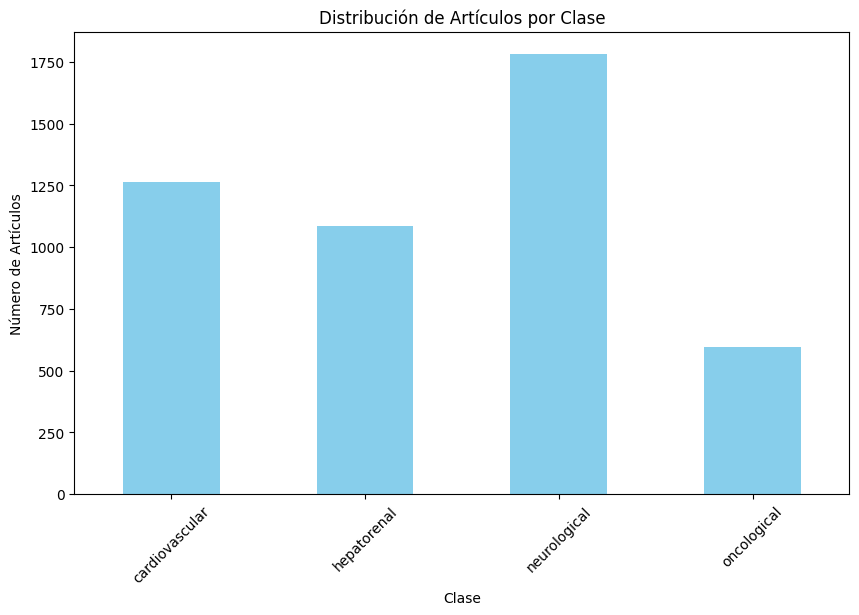

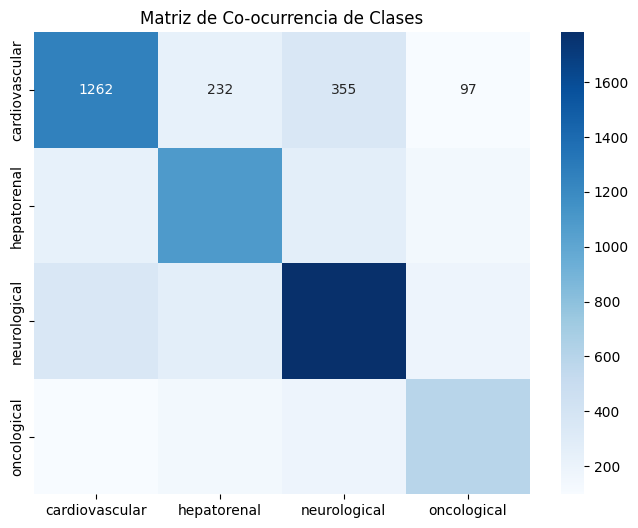

c:\Users\CRISTIAN\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


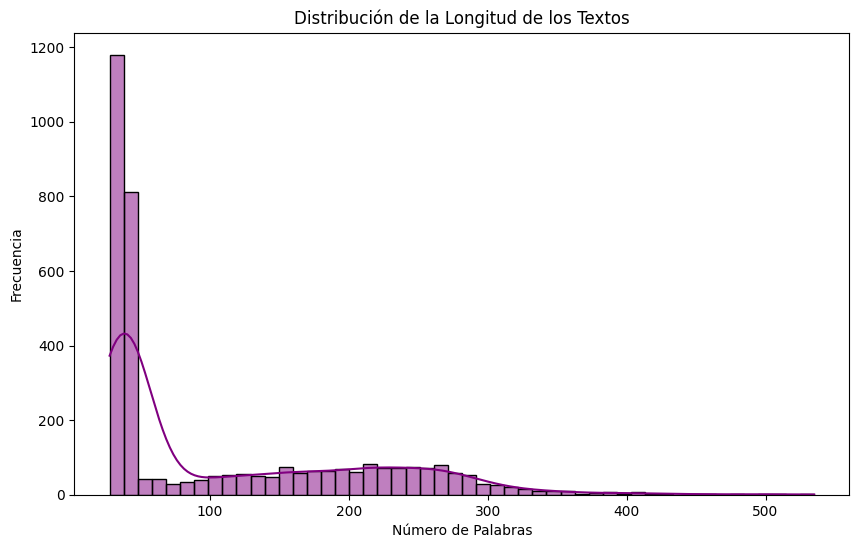


--- Preprocesamiento y Vectorización ---


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\CRISTIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df['group'] = df['group'].apply(lambda x: str(x).split('|'))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['group'])
target_labels = mlb.classes_
df_labels = pd.DataFrame(y, columns=target_labels)
df = pd.concat([df, df_labels], axis=1)

print("\nColumnas de etiquetas creadas:")
print(df[target_labels].head())

# --- 3. Análisis Exploratorio de Datos (EDA) ---
print("\n--- Análisis Exploratorio de Datos (EDA) ---")
class_counts = df[target_labels].sum()
print("\nNúmero de artículos por cada clase:")
print(class_counts)

# Visualizaciones de EDA (se guardarán como archivos PNG)
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Artículos por Clase')
plt.xlabel('Clase')
plt.ylabel('Número de Artículos')
plt.xticks(rotation=45)
plt.savefig('class_distribution.png')
plt.show()

co_occurrence_matrix = df[target_labels].T.dot(df[target_labels])
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_labels, yticklabels=target_labels)
plt.title('Matriz de Co-ocurrencia de Clases')
plt.savefig('co_occurrence_matrix.png')
plt.show()

df['text_combined'] = df['title'] + " " + df['abstract']
df['text_length'] = df['text_combined'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='purple')
plt.title('Distribución de la Longitud de los Textos')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.savefig('text_length_distribution.png')
plt.show()

# --- 4. Preprocesamiento y Vectorización del Texto ---
print("\n--- Preprocesamiento y Vectorización ---")
# Descarga los recursos de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [3]:
# 1. Preparar textos originales y etiquetas
df['text_combined'] = df['title'] + " " + df['abstract']
df['cleaned_text'] = df['text_combined'].apply(preprocess_text)

X_text = df[['title', 'abstract', 'cleaned_text']]   # <- textos originales
y = df[target_labels]

# 2. Vectorizar solo el texto limpio
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X_text['cleaned_text'])


# 3. Split consistente para textos y TF-IDF
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=12
)

# 4. Resetear solo DataFrames
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print("\nDatos listos para el modelado.")
print(f"Forma de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test_tfidf: {X_test_tfidf.shape}")
print(f"Forma de y_test: {y_test.shape}")



Datos listos para el modelado.
Forma de X_train_tfidf: (2836, 5000)
Forma de y_train: (2836, 4)
Forma de X_test_tfidf: (710, 5000)
Forma de y_test: (710, 4)


In [4]:
from tensorflow.keras import regularizers

# Convertir la matriz dispersa de TF-IDF a densa
# Convertir la matriz dispersa de TF-IDF a densa para Keras
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

print("\n--- Construyendo la Red Neuronal ---")
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))


model.add(Dense(len(target_labels), activation='sigmoid'))

model.summary()


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

history = model.fit(X_train_dense, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)

print("\n--- Evaluación del Modelo de Red Neuronal ---")
loss, accuracy = model.evaluate(X_test_dense, y_test, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")



--- Construyendo la Red Neuronal ---


c:\Users\CRISTIAN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,668 (5.04 MB)

 Trainable params: 1,321,668 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3306 - loss: 1.0191 - val_accuracy: 0.4965 - val_loss: 0.6205
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6637 - loss: 0.5496 - val_accuracy: 0.7289 - val_loss: 0.4645
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8236 - loss: 0.4058 - val_accuracy: 0.7958 - val_loss: 0.4239
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8467 - loss: 0.3686 - val_accuracy: 0.7711 - val_loss: 0.4245
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8358 - loss: 0.3585 - val_accuracy: 0.7676 - val_loss: 0.4255
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8484 - loss: 0.3342 - val_accuracy: 0.7958 - val_loss: 0.4116
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8377 - loss: 0.3334 - val_accuracy: 0.8063 - val_loss: 0.4249
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8439 - loss: 0.3217 - val_accuracy: 0.7817 - v

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision (weighted): 0.9138
Recall (weighted): 0.8283
F1-Score (weighted): 0.8649
ROC-AUC (weighted): 0.9538


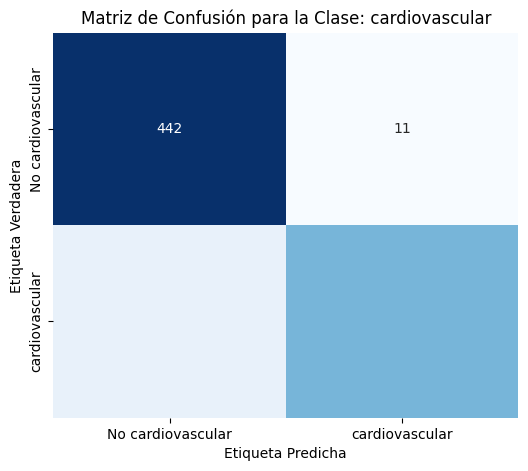

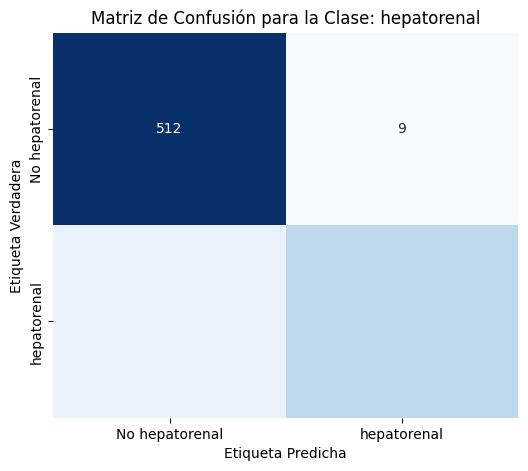

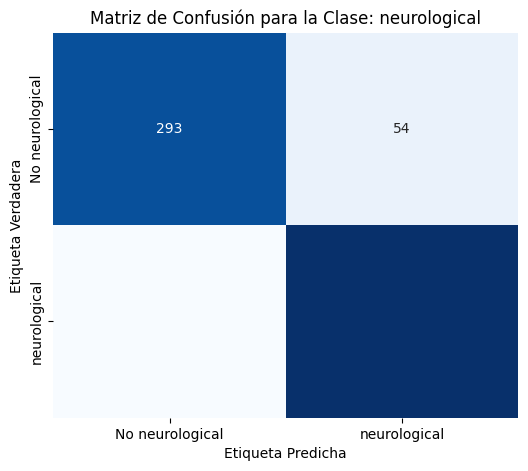

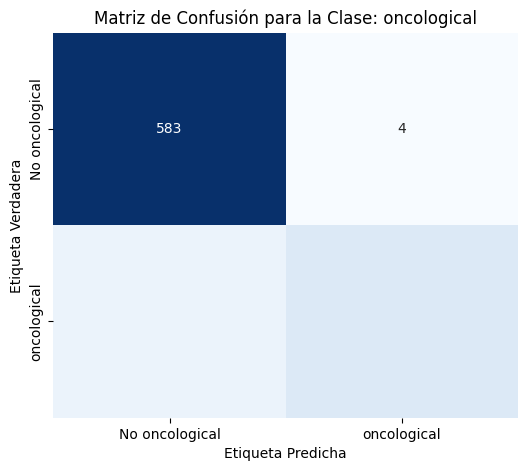

In [6]:
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calcular métricas adicionales
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')

print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"ROC-AUC (weighted): {roc_auc:.4f}")

# Visualizar la matriz de confusión para cada clase
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(target_labels):
    cm = conf_matrices[i]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No ' + label, label],
                yticklabels=['No ' + label, label])
    plt.title(f'Matriz de Confusión para la Clase: {label}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

In [7]:
df_pred_proba = pd.DataFrame(y_pred_proba, columns=[f"proba_{label}" for label in target_labels])
df_pred = pd.DataFrame(y_pred, columns=target_labels)   # predicciones 0/1
df_true = pd.DataFrame(y_test, columns=target_labels)   # valores reales


X_test_texts = df.loc[y_test.index, ['title', 'abstract']].reset_index(drop=True)


df_pred["prediccion_group"] = df_pred.apply(
    lambda row: ", ".join([label for label, val in row.items() if val == 1]) or "Ninguno", axis=1
)


df_true["true_group"] = df_true.apply(
    lambda row: ", ".join([label for label, val in row.items() if val == 1]) or "Ninguno", axis=1
)

df_results = pd.concat([X_test_texts, df_true["true_group"], df_pred["prediccion_group"], df_pred_proba], axis=1)

# Guardar a CSV
output_file = "predicciones_resultados.csv"
df_results.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"Archivo '{output_file}' generado con éxito ✅")


Archivo 'predicciones_resultados.csv' generado con éxito ✅


In [ ]:
# --- 1. Definir el nuevo artículo ---
val = pd.read_excel("../data/prueba.xlsx")

for col in ['title', 'abstract', "group_real"]:
    val[col] = val[col].fillna('')


for index, row in val.iterrows():

    nuevo_texto_combinado = row['title'] + " " + row['abstract']

    nuevo_texto_limpio = preprocess_text(nuevo_texto_combinado)


    nuevo_texto_vectorizado = vectorizer.transform([nuevo_texto_limpio])


    nuevo_texto_vectorizado_dense = nuevo_texto_vectorizado.toarray()


    prediccion_proba = model.predict(nuevo_texto_vectorizado_dense)[0]


    umbral = 0.5
    prediccion_binaria = (prediccion_proba > umbral).astype(int)


    etiquetas_predichas = mlb.inverse_transform(prediccion_binaria.reshape(1, -1))[0]

    print("\n" + "="*50)
    print(f"--- Artículo #{index + 1} ---")
    print(f"Título: {row['title']}")
    print(f"Abstract: {row['abstract']}")
    print("\nEtiquetas predichas:")
    
    # === CORRECCIÓN AQUÍ: SE USA 'len()' EN LUGAR DE '.size' ===
    if len(etiquetas_predichas) > 0:
        for etiqueta in etiquetas_predichas:
            print(f"- {etiqueta}")
    else:
        print("- No se predijo ninguna etiqueta.")

    print(f"\nEtiquetas reales: \n- {row['group_real'] if row['group_real'] else 'Ninguna'}")

    print("\nProbabilidades de la predicción:")
    for i, label in enumerate(mlb.classes_):
        print(f"- {label}: {prediccion_proba[i]:.4f}")
    
    print("="*50 + "\n")

In [ ]:
from sklearn.metrics import classification_report

# Generar el informe de clasificación
# 'target_labels' son los nombres de tus clases: ['Cardiovascular', 'Hepatrenal', 'Neurological', 'Oncological']
report = classification_report(y_test, y_pred, target_names=target_labels, zero_division=0)
print("\n--- Informe de Clasificación por Clase ---")
print(report)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd

# Suponiendo que ya tienes 'y_test' y 'y_pred' de los pasos anteriores.
# Si estás ejecutando este código por separado, asegúrate de tener las variables disponibles.
# Ejemplo de inicialización (si lo necesitas):
# y_test = df[target_labels].iloc[X_test_indices].values
# y_pred = multi_output_model.predict(X_test)

# Generar las matrices de confusión para cada etiqueta
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Crear un DataFrame para una visualización más clara de los resultados
metrics = []
for i, label in enumerate(target_labels):
    tn, fp, fn, tp = conf_matrices[i].ravel()
    metrics.append({
        'Clase': label,
        'Verdaderos Positivos (TP)': tp,
        'Falsos Positivos (FP)': fp,
        'Falsos Negativos (FN)': fn,
        'Verdaderos Negativos (TN)': tn
    })

confusion_df = pd.DataFrame(metrics)
confusion_df.set_index('Clase', inplace=True)

print("\n--- Matriz de Confusión para cada Clase ---")
print(confusion_df)